In [1]:
%matplotlib inline

import sys
import math
import outliers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

prescription = pd.read_csv('data/prescriptions2017_clean.csv.gz', compression='gzip')

In [2]:
medications = outliers.getOverdoseMedications(prescription)
medications.shape

(73,)

In [3]:
all_times  = []

for med in np.asarray(medications):

    methods_time = pd.DataFrame()
    
    X, Y = outliers.getPrescriptions(prescription, med)
    anomalies = len(Y[Y==1])
    total = len(X)
    
    if len(X) < 30000:
        continue

    print(med + ', Size: ', total, ' Overdose: ', anomalies)
        
    index_list = np.append([], [])
    skf = StratifiedKFold(n_splits=anomalies)
    div = 1
    for train_index, test_index in skf.split(X, Y):
            
            
        index_list = np.append(index_list.astype(int), test_index.astype(int))
        size = len(index_list)
            
        X_train = X[index_list]
        Y_train = Y[index_list]
        overdose_size = len(Y_train[Y_train==1])
        
        if (size // 3000) < div:
            continue
            
        size_idx = div * 3000
        div = 1 + (size // 3000)
        
        sys.stdout.write(str(overdose_size) + '/' + str(size) +', ')
            
        epsilon = 0.5
        p_svm = [epsilon,4]
        p_cov = [epsilon]
        p_ift = [epsilon]
        p_lof = [500,epsilon]
        p_wpr = [epsilon]
        p_gmx = [epsilon]
        results = outliers.evaluateMethods(X_train, Y_train, p_svm, p_cov, p_ift, p_lof, p_wpr, p_gmx, debug=False)

        for idx in results.index:
            methods_time.loc[idx, size_idx] = results.loc[idx,'Time']

        if size > 30000:
            break

    all_times.append(methods_time)
        #break
    
    if len(all_times) > 5:
        break
            
print('Done')

DIPIRONA 1 g/2 ml SOL INJ, Size:  163027  Overdose:  618
12/3168, 23/6072, 35/9240, 46/12144, 57/15048, 69/18216, 80/21120, 91/24024, 103/27192, 114/30096, LACTULOSE 667 mg/ml SOL ORAL, Size:  33395  Overdose:  90
9/3344, 17/6312, 25/9280, 33/12248, 41/15216, 49/18184, 57/21152, 65/24120, 73/27088, 81/30056, PARACETAMOL 500 mg CP, Size:  82749  Overdose:  116
5/3570, 9/6426, 13/9282, 17/12138, 22/15708, 26/18564, 30/21420, 34/24276, 38/27132, 43/30700, Done


In [4]:
all_times[1]

,3000,6000,9000,12000,15000,18000,21000,24000,27000,30000
LOF,0.399,0.840,1.373,1.743,2.432,3.008,3.651,4.108,4.688,5.007
Gau,0.008,0.009,0.016,0.022,0.024,0.028,0.035,0.035,0.039,0.044
SVM,0.264,0.922,1.994,3.553,5.589,8.091,11.128,14.677,18.650,23.290
IsoF,0.314,0.496,0.676,0.867,1.054,1.238,1.427,1.625,1.784,1.969
DDC-H,0.051,0.064,0.071,0.086,0.092,0.140,0.100,0.117,0.122,0.129
DDC-C,0.072,0.088,0.105,0.132,0.145,0.160,0.164,0.200,0.206,0.223
DDC-J,0.041,0.048,0.053,0.062,0.065,0.070,0.072,0.080,0.084,0.087
DDC,0.049,0.059,0.068,0.081,0.087,0.094,0.096,0.110,0.114,0.121
Cov,0.494,0.554,0.599,0.716,0.888,1.016,1.168,1.282,1.393,1.549
DDC-M,0.058,0.072,0.083,0.101,0.110,0.117,0.118,0.139,0.145,0.154


In [6]:
mean_time = pd.DataFrame(np.zeros((10,10)), index=results.index, columns=np.arange(3000,30001,3000))

for df in all_times:
    for m in df.index:
        for s in df.columns:
            mean_time.loc[m,s] += df.loc[m,s]

mean_time = ( mean_time.values / len(all_times) )
mean_time = pd.DataFrame(mean_time, index=results.index, columns=np.arange(3000,30001,3000))
mean_time

,3000,6000,9000,12000,15000,18000,21000,24000,27000,30000
LOF,0.436667,0.887667,1.484667,1.974000,2.754000,3.541000,4.261667,5.006000,5.903667,6.678000
Gau,0.007667,0.008667,0.012667,0.016333,0.019333,0.022333,0.026000,0.027333,0.030667,0.034000
SVM,0.193000,0.670000,1.458000,2.515000,4.008000,5.756333,7.816000,10.229667,12.972667,16.262667
IsoF,0.250667,0.388000,0.525333,0.659667,0.808000,0.944333,1.111000,1.260333,1.385667,1.540000
DDC-H,0.030000,0.036333,0.041333,0.048000,0.052000,0.069333,0.057667,0.064333,0.067333,0.071000
DDC-C,0.037667,0.045333,0.054333,0.065000,0.072000,0.077667,0.081333,0.094333,0.097667,0.104333
DDC-J,0.025333,0.029667,0.033667,0.038333,0.041000,0.044000,0.046667,0.050000,0.053000,0.054667
DDC,0.028333,0.033667,0.039667,0.046000,0.049333,0.053000,0.055333,0.061000,0.063667,0.066667
Cov,0.351000,0.421000,0.471333,0.560000,0.664000,0.765333,0.886333,0.992667,1.105000,1.234000
DDC-M,0.032333,0.039000,0.045333,0.053000,0.057667,0.061333,0.063667,0.071667,0.075000,0.078667


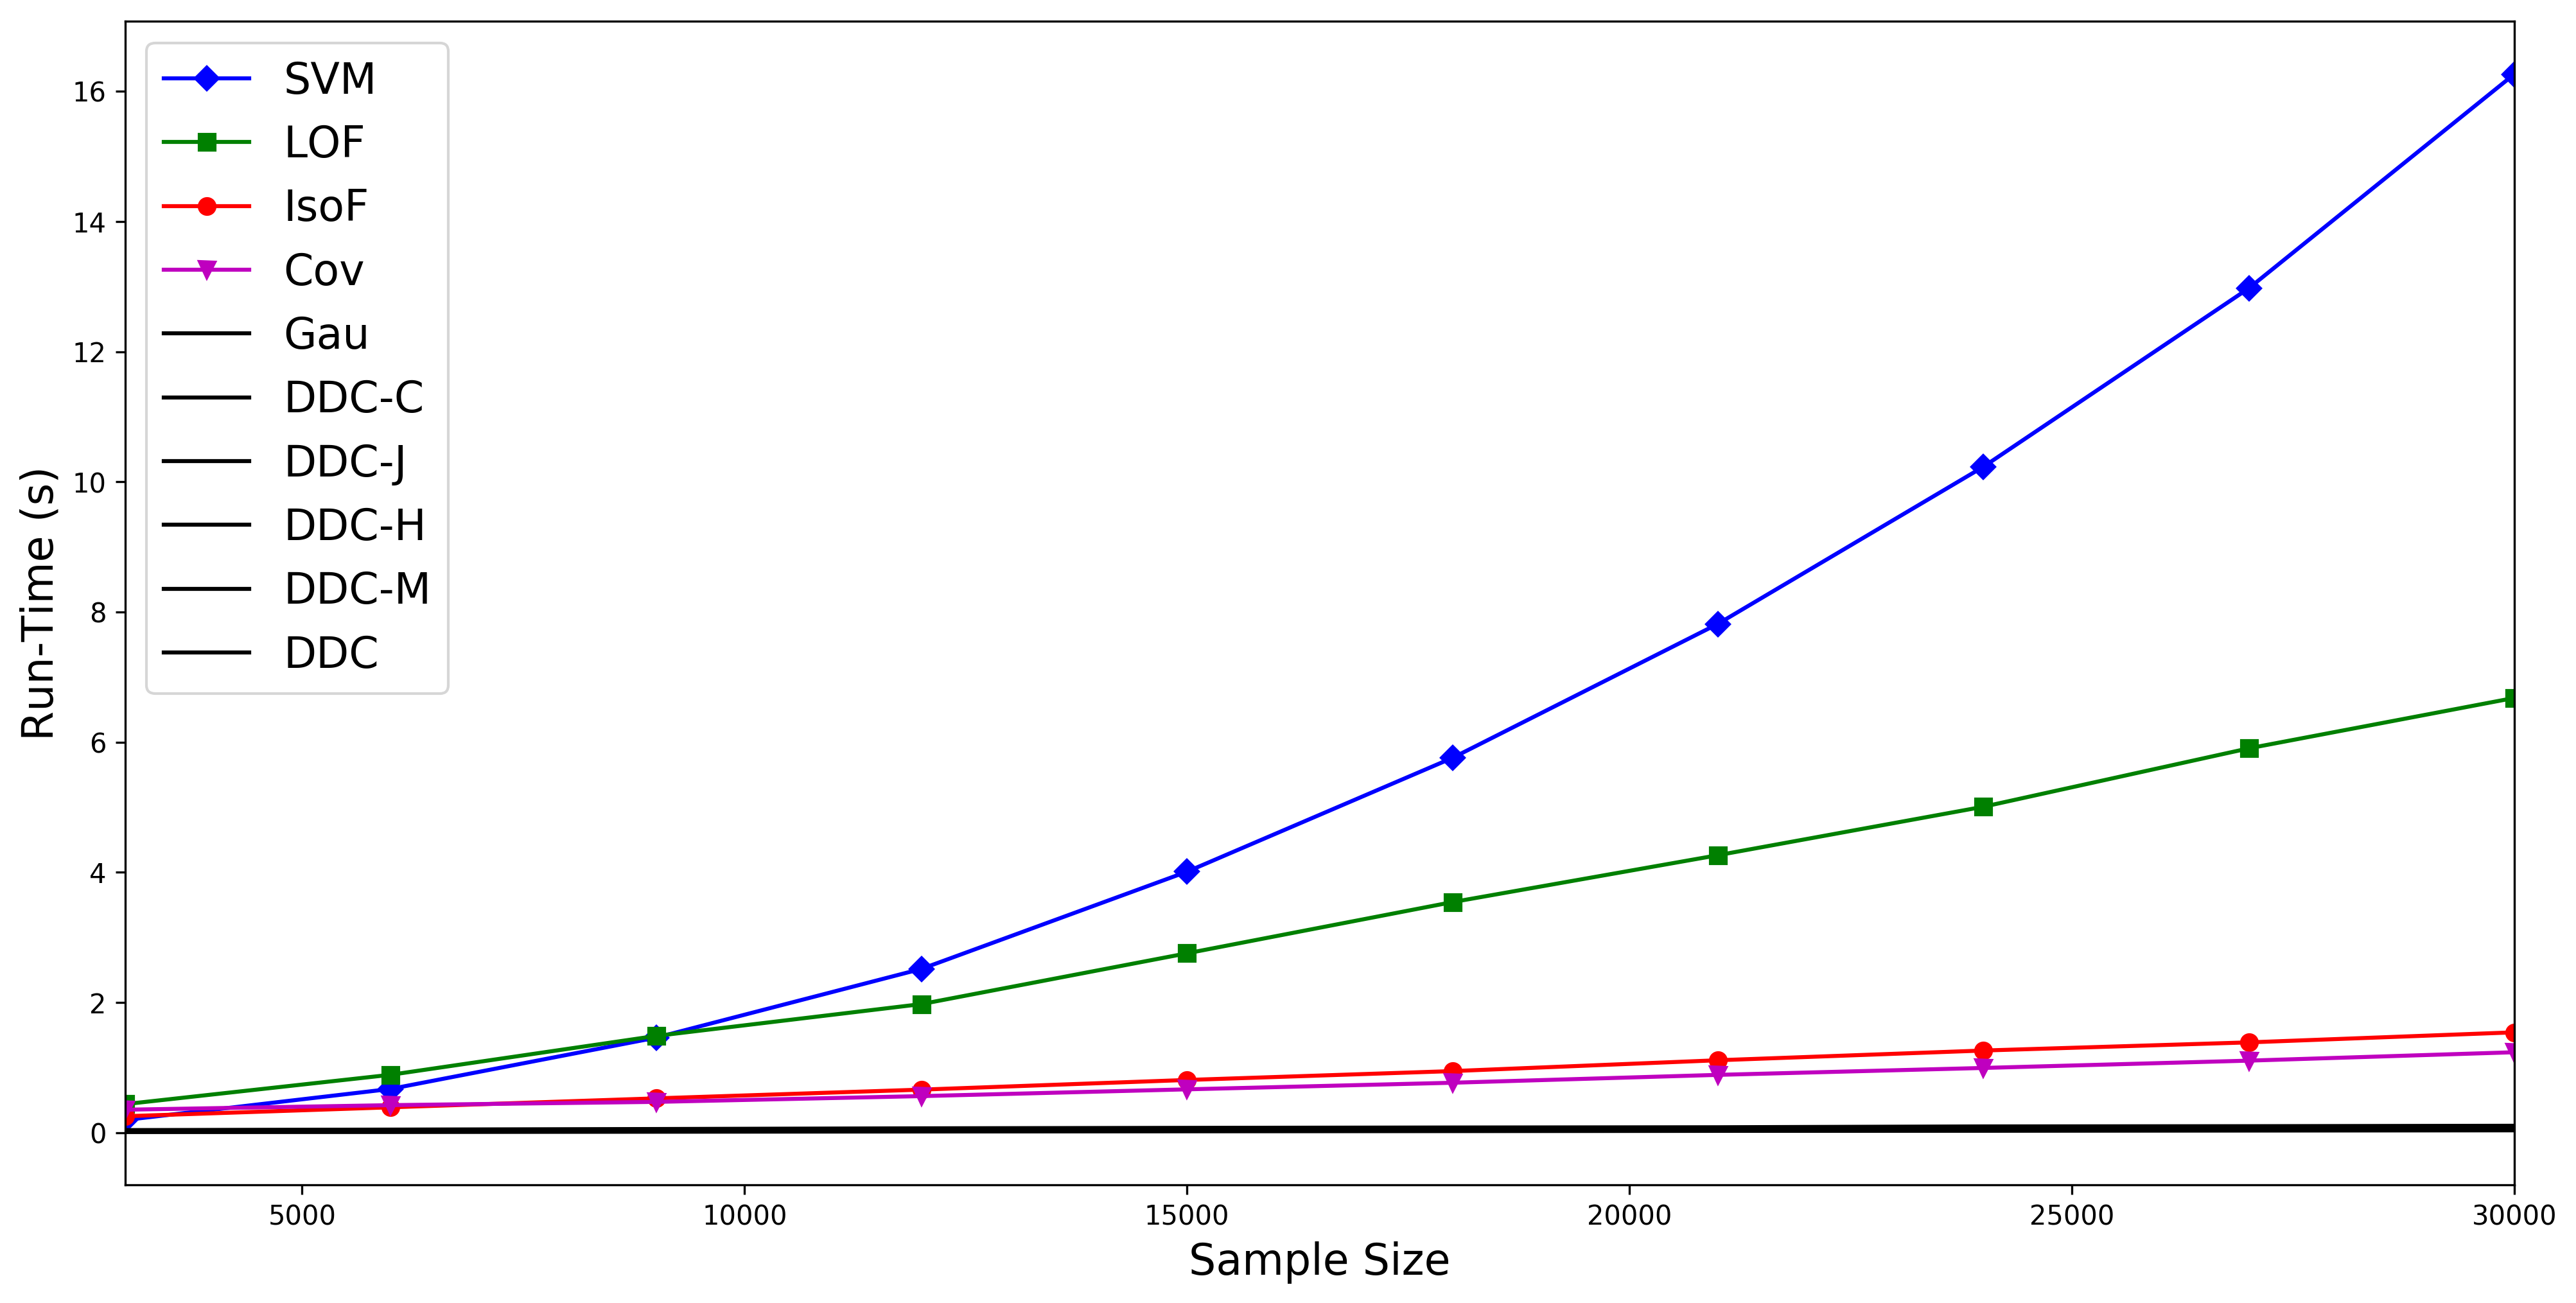

In [20]:
plt.figure(figsize=(16, 8), dpi= 300)
methods = ['SVM','LOF','IsoF','Cov','Gau','DDC-C','DDC-J','DDC-H','DDC-M','DDC']
colors = ['b', 'g', 'r', 'm', 'k', 'k', 'k', 'k', 'k', 'k']
markers = ['D', 's', 'o', 'v', '', '', '', '', '', '']
i = 0
for m in methods:
    plt.plot(np.asarray(mean_time.columns),np.asarray(mean_time.loc[m].values), 
             c=colors[i],
             marker=markers[i],
             label=m)
    i += 1
    
plt.legend(fontsize=16)
plt.xlabel('Sample Size', fontsize=16)
plt.ylabel('Run-Time (s)', fontsize=16)
#plt.ylim(0,22)
plt.xlim(3000,30000)
plt.show()